## Metadata and Annotations: Cleaning and Preprocessing

**Author**: Calvin Chan

**Data**: PTB-XL (https://physionet.org/content/ptb-xl/1.0.3/)

### Introduction
In this notebook we will go through the cleaning and preprocessing of our two additional CSV files `ptbxl_database.csv` and `scp_statements.csv`. These files contain patient information that go along with each ECG signal as well its diagnostic superclass (ECG  diagnosis) which we will be using for our project.

### Table of Contents
- [Data Dictionary](#dictionary)
- [Diagnostic Classes](#classes)
- [Procedures](#procedures)
- [Annotations](#annotations)
- [Metadata Cleaning](#metadata)
- [References](#references)

<a id='dictionary'></a>
### Data Dictionary
Here we present the data dictionaries for the two files in `PTB-XL` that we will be using. Metadata contains information about the patient who took the ECG while Annotation contains the standard SCP-ECG codes. Some of the descriptions are taken from or interpreted with the help of [Wagner et al. (2020)](#1).

- **Metadata file** (`ptbxl_database.csv`): 

| Column                       | Data Types | Description                                                     |
|------------------------------|------------|-----------------------------------------------------------------|
| patient_id                   | float      | Unique patient ID                                               |
| age                          | float      | Age in years                                                    |
| sex                          | integer    | Sex (M/F)                                                       |
| height                       | float      | Height in centimeters                                           |
| weight                       | float      | Weight in kilograms                                             |
| nurse                        | float      | Nurse that took the ECG (placeholder value)                     |
| site                         | float      | Site in which ECG was recorded                                  |
| device                       | string     | Device used to record ECG                                       |
| recording_date               | datetime   | Date time when ECG was recorded                                 |
| report                       | string     | Report by cardiologist or automatic intepretation by ECG device |
| scp_codes                    | dictionary | Standardized SCP-ECG statements                                 |
| heart_axis                   | string     | Hearts overall electrical activity direction                    |
| infarction_stadium1          | string     | First infarction stadium                                        |
| infarction_stadium2          | string     | Second infarction stadium                                       |
| validated_by                 | float      | Cardiologist that validated signal (placeholder value)          |
| second_opinion               | boolean    | Second opinion required                                         |
| initial_autogenerated_report | boolean    | Autogenerated report by ECG device                              |
| validated_by_human           | boolean    | Results validated by human                                      |
| baseline_drift               | string     | Leads with baseline drift                                       |
| static_noise                 | string     | Leads with static noise                                         |
| burst_noise                  | string     | Leads with burst noise                                          |
| electrodes_problems          | string     | Leads with electrode problem                                    |
| extra_beats                  | string     | Extra beats present                                             |
| pacemaker                    | string     | Pacemaker present in patient                                    |
| strat_fold                   | integer    | Suggested stratified folds for train test split                 |
| filename_lr                  | string     | Low sampling rate file path                                     |
| filename_hr                  | string     | High sampling rate file path                                    |

- **Annotation file** (`scp_statements.csv`): 

| Column                        | Data Types | Description                     |
|-------------------------------|------------|---------------------------------|
| description                   | string     | Annotation description          |
| diagnostic                    | float      | Related to diagnosis            |
| form                          | float      | Related to signal form          |
| rhythm                        | float      | Related to rhythm               |
| diagnostic_class              | string     | Superclass for diagnosis        |
| diagnostic_subclass           | string     | Subclass for diagnosis          |
| statement category            | string     | Medical description             |
| SCP-ECG statement description | string     | Official SCP-ECG description    |
| AHA code                      | float      | Unique AHA ID                   |
| aECG REFID                    | string     | Annotated ECG standard notation |
| CDISC code                    | string     | Controlled terminology          |
| DICOM code                    | string     | DICOM tags                      |


<a id='classes'></a>
### Diagnostic Classes

In general, ECG signals can show many conditions, however, for our simplicity we will categorize them into larger groups called superclasses. This is readily done in the annotation file where they categorized different conditions into five diagnostic superclasses:

| # Records | Superclass | Description            | Common Name                      |
|-----------|------------|------------------------|--------------------------------- |
| 9514      | NORM       | Normal ECG             | Normal                           |
| 5469      | MI         | Myocardial Infarction  | Heart Attack                     |
| 5235      | STTC       | ST/T Change            | Changes in ST Segment and T Wave |
| 4898      | CD         | Conduction Disturbance | Heart Blocks                     |
| 2649      | HYP        | Hypertrophy            | Enlarged Cardiac Muscles         |

> **Note**: The sum of the number of records here is more than the number of rows in the data because some ECG recordings show more than one condition.

<a id='procedures'></a>
### Procedures
Here we go through the general steps that we will perform throughout this notebook and the `ecg_cleaning` notebook as well.

1. Import diagnostics from annotation (`scp_statements.csv`) and add them to metadata (`ptbxl_database.csv`)   
    - Use `scp_code` column in metadata to get the diagnostic superclass
2. Clean metadata (can be done simultaneously with step 3)
    - Metadata `NaN` values
        - if rows dropped, need to drop corresponding signal too
3. Clean ECG signals 
    - Denoise using Fourier Transforms 
4. EDA 
    - Checking to see if there are any noticeable patterns for each diagnostic superclass

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb
import ast

%autosave 300

Autosaving every 300 seconds


<a id='annotations'></a>
### Annotations

For this section, we will look at the `scp_statements.csv` file which contains a list of statements called **Standard Communications Protocol for Computer Assisted Electrocardiography** (SCP-ECG). These are a set of standard formats for storing ECG data, metadata and annotations universally. In our metadata file (`ptbxl_database.csv`) we have a column that contains SCP codes, which is where we will extract the diagnosis of the corresponding ECG from using the list of statements. 

>**Note**: Some of the following code blocks in this section were taken from `example_physionet.py` included in the data set and can be found [here](https://physionet.org/content/ptb-xl/1.0.3/example_physionet.py). 

Let's look at the SCP codes first in our metadata file:

In [2]:
# Load metadata file
path = '../data/physionet.org/files/ptb-xl/1.0.3/'

metadata = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')

In [3]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21799 entries, 1 to 21837
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    21799 non-null  float64
 1   age                           21799 non-null  float64
 2   sex                           21799 non-null  int64  
 3   height                        6974 non-null   float64
 4   weight                        9421 non-null   float64
 5   nurse                         20326 non-null  float64
 6   site                          21782 non-null  float64
 7   device                        21799 non-null  object 
 8   recording_date                21799 non-null  object 
 9   report                        21799 non-null  object 
 10  scp_codes                     21799 non-null  object 
 11  heart_axis                    13331 non-null  object 
 12  infarction_stadium1           5612 non-null   object 
 13  infarc

Since we have a lot of columns, by default Pandas would not show all of them. However, we can temporarily make it show all using the following code from [this](https://stackoverflow.com/questions/11707586/how-do-i-expand-the-output-display-to-see-more-columns-of-a-pandas-dataframe) website.

In [4]:
# Temporarily show all columns using Pandas
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print("Metadata head:")
    display(metadata.head())
    print("Metadata tail:")
    display(metadata.tail())

Metadata head:


patient_id   age  sex  height  weight  nurse  site     device  \
ecg_id                                                                  
1          15709.0  56.0    1     NaN    63.0    2.0   0.0  CS-12   E   
2          13243.0  19.0    0     NaN    70.0    2.0   0.0  CS-12   E   
3          20372.0  37.0    1     NaN    69.0    2.0   0.0  CS-12   E   
4          17014.0  24.0    0     NaN    82.0    2.0   0.0  CS-12   E   
5          17448.0  19.0    1     NaN    70.0    2.0   0.0  CS-12   E   

             recording_date                                  report  \
ecg_id                                                                
1       1984-11-09 09:17:34  sinusrhythmus periphere niederspannung   
2       1984-11-14 12:55:37     sinusbradykardie sonst normales ekg   
3       1984-11-15 12:49:10              sinusrhythmus normales ekg   
4       1984-11-15 13:44:57              sinusrhythmus normales ekg   
5       1984-11-17 10:43:15              sinusrhythmus normales ekg   

                                       scp_codes heart_axis  \
ecg_id                                                        
1       {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}        NaN   
2                   {'NORM': 80.0, 'SBRAD': 0.0}        NaN   
3                     {'NORM': 100.0, 'SR': 0.0}        NaN   
4                     {'NORM': 100.0, 'SR': 0.0}        NaN   
5                     {'NORM': 100.0, 'SR': 0.0}        NaN   

       infarction_stadium1 infarction_stadium2  validated_by  second_opinion  \
ecg_id                                                                         
1                      NaN                 NaN           NaN           False   
2                      NaN                 NaN           NaN           False   
3                      NaN                 NaN           NaN           False   
4                      NaN                 NaN           NaN           False   
5                      NaN                 NaN           NaN           False   

        initial_autogenerated_report  validated_by_human  baseline_drift  \
ecg_id                                                                     
1                              False                True             NaN   
2                              False                True             NaN   
3                              False                True             NaN   
4                              False                True    , II,III,AVF   
5                              False                True   , III,AVR,AVF   

       static_noise burst_noise electrodes_problems extra_beats pacemaker  \
ecg_id                                                                      
1         , I-V1,           NaN                 NaN         NaN       NaN   
2               NaN         NaN                 NaN         NaN       NaN   
3               NaN         NaN                 NaN         NaN       NaN   
4               NaN         NaN                 NaN         NaN       NaN   
5               NaN         NaN                 NaN         NaN       NaN   

        strat_fold                filename_lr                filename_hr  
ecg_id                                                                    
1                3  records100/00000/00001_lr  records500/00000/00001_hr  
2                2  records100/00000/00002_lr  records500/00000/00002_hr  
3                5  records100/00000/00003_lr  records500/00000/00003_hr  
4                3  records100/00000/00004_lr  records500/00000/00004_hr  
5                4  records100/00000/00005_lr  records500/00000/00005_hr

Metadata tail:


patient_id    age  sex  height  weight  nurse  site      device  \
ecg_id                                                                    
21833      17180.0   67.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21834      20703.0  300.0    0     NaN     NaN    1.0   2.0  AT-60    3   
21835      19311.0   59.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21836       8873.0   64.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21837      11744.0   68.0    0     NaN     NaN    1.0   2.0  AT-60    3   

             recording_date  \
ecg_id                        
21833   2001-05-31 09:14:35   
21834   2001-06-05 11:33:39   
21835   2001-06-08 10:30:27   
21836   2001-06-09 18:21:49   
21837   2001-06-11 16:43:01   

                                                   report  \
ecg_id                                                      
21833   ventrikulÄre extrasystole(n) sinustachykardie ...   
21834   sinusrhythmus lagetyp normal qrs(t) abnorm    ...   
21835   sinusrhythmus lagetyp normal t abnorm in anter...   
21836   supraventrikulÄre extrasystole(n) sinusrhythmu...   
21837   sinusrhythmus p-sinistrocardiale lagetyp norma...   

                                                scp_codes heart_axis  \
ecg_id                                                                 
21833   {'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...        LAD   
21834            {'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}        MID   
21835                          {'ISCAS': 50.0, 'SR': 0.0}        MID   
21836                          {'NORM': 100.0, 'SR': 0.0}        LAD   
21837                          {'NORM': 100.0, 'SR': 0.0}        MID   

       infarction_stadium1 infarction_stadium2  validated_by  second_opinion  \
ecg_id                                                                         
21833                  NaN                 NaN           1.0           False   
21834       Stadium II-III                 NaN           1.0           False   
21835                  NaN                 NaN           1.0            True   
21836                  NaN                 NaN           1.0           False   
21837                  NaN                 NaN           1.0           False   

        initial_autogenerated_report  validated_by_human baseline_drift  \
ecg_id                                                                    
21833                           True                True            NaN   
21834                           True                True            NaN   
21835                           True                True            NaN   
21836                           True                True            NaN   
21837                           True                True            NaN   

       static_noise burst_noise electrodes_problems extra_beats pacemaker  \
ecg_id                                                                      
21833    , alles,           NaN                 NaN         1ES       NaN   
21834           NaN         NaN                 NaN         NaN       NaN   
21835    , I-AVR,           NaN                 NaN         NaN       NaN   
21836           NaN         NaN                 NaN        SVES       NaN   
21837    , I-AVL,           NaN                 NaN         NaN       NaN   

        strat_fold                filename_lr                filename_hr  
ecg_id                                                                    
21833            7  records100/21000/21833_lr  records500/21000/21833_hr  
21834            4  records100/21000/21834_lr  records500/21000/21834_hr  
21835            2  records100/21000/21835_lr  records500/21000/21835_hr  
21836            8  records100/21000/21836_lr  records500/21000/21836_hr  
21837            9  records100/21000/21837_lr  records500/21000/21837_hr

We can check for duplicated rows first. 


In [5]:
metadata.duplicated().sum()

0

As we can see there are no duplicated rows, as such we will move on to getting the annotations from `scp_statements.csv` on to our metadata file first. We will begin further analysis and cleaning in the next section of this notebook.

Let's focus on the `scp_codes` column and see how the values are interpreted by Pandas. 

In [6]:
metadata['scp_codes'].iloc[0]

"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}"

We see that Pandas interprets the dictionaries in `scp_codes` as literal strings. This can by updated by applying the `literal_eval()` function from the `ast` library.

In [7]:
# Pandas probably read the scp_codes as strings, we can change them to be interpreted as dictionaries with ast
metadata['scp_codes'] = metadata['scp_codes'].apply(lambda x: ast.literal_eval(x)) 

In [8]:
metadata['scp_codes'].iloc[0]

{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}

Now we see that the string got turned back into a dictionary and so we can use this column to tell us the diagnostic superclass for each ECG.

Let's load our annotation file now and see the kinds of SCP statements we have. 

In [9]:
annot = pd.read_csv(path + 'scp_statements.csv', index_col=0)

In [10]:
annot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71 entries, NDT to TRIGU
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   description                    71 non-null     object 
 1   diagnostic                     44 non-null     float64
 2   form                           19 non-null     float64
 3   rhythm                         12 non-null     float64
 4   diagnostic_class               44 non-null     object 
 5   diagnostic_subclass            44 non-null     object 
 6   Statement Category             71 non-null     object 
 7   SCP-ECG Statement Description  71 non-null     object 
 8   AHA code                       37 non-null     float64
 9   aECG REFID                     23 non-null     object 
 10  CDISC Code                     13 non-null     object 
 11  DICOM Code                     13 non-null     object 
dtypes: float64(4), object(8)
memory usage: 7.2+ KB


In [11]:
# Head and tail of data
print("Annotation head:")
display(annot.head())
print("Annotation tail:")
display(annot.tail())

Annotation head:


description  diagnostic  form  rhythm  \
NDT    non-diagnostic T abnormalities         1.0   1.0     NaN   
NST_          non-specific ST changes         1.0   1.0     NaN   
DIG                  digitalis-effect         1.0   1.0     NaN   
LNGQT                long QT-interval         1.0   1.0     NaN   
NORM                       normal ECG         1.0   NaN     NaN   

      diagnostic_class diagnostic_subclass  \
NDT               STTC                STTC   
NST_              STTC                NST_   
DIG               STTC                STTC   
LNGQT             STTC                STTC   
NORM              NORM                NORM   

                                      Statement Category  \
NDT                    other ST-T descriptive statements   
NST_   Basic roots for coding ST-T changes and abnorm...   
DIG                    other ST-T descriptive statements   
LNGQT                  other ST-T descriptive statements   
NORM                                     Normal/abnormal   

        SCP-ECG Statement Description  AHA code            aECG REFID  \
NDT    non-diagnostic T abnormalities       NaN                   NaN   
NST_          non-specific ST changes     145.0  MDC_ECG_RHY_STHILOST   
DIG         suggests digitalis-effect     205.0                   NaN   
LNGQT                long QT-interval     148.0                   NaN   
NORM                       normal ECG       1.0                   NaN   

      CDISC Code DICOM Code  
NDT          NaN        NaN  
NST_         NaN        NaN  
DIG          NaN        NaN  
LNGQT        NaN        NaN  
NORM         NaN    F-000B7

Annotation tail:


description  diagnostic  form  \
BIGU   bigeminal pattern (unknown origin, SV or Ventr...         NaN   NaN   
AFLT                                      atrial flutter         NaN   NaN   
SVTAC                       supraventricular tachycardia         NaN   NaN   
PSVT             paroxysmal supraventricular tachycardia         NaN   NaN   
TRIGU  trigeminal pattern (unknown origin, SV or Vent...         NaN   NaN   

       rhythm diagnostic_class diagnostic_subclass  \
BIGU      1.0              NaN                 NaN   
AFLT      1.0              NaN                 NaN   
SVTAC     1.0              NaN                 NaN   
PSVT      1.0              NaN                 NaN   
TRIGU     1.0              NaN                 NaN   

                                      Statement Category  \
BIGU   Statements related to ectopic rhythm abnormali...   
AFLT   Statements related to impulse formation (abnor...   
SVTAC  Statements related to impulse formation (abnor...   
PSVT   Statements related to impulse formation (abnor...   
TRIGU  Statements related to ectopic rhythm abnormali...   

                           SCP-ECG Statement Description  AHA code  \
BIGU   bigeminal pattern (unknown origin, SV or Ventr...       NaN   
AFLT                                      atrial flutter      51.0   
SVTAC                       supraventricular tachycardia      55.0   
PSVT             paroxysmal supraventricular tachycardia       NaN   
TRIGU  trigeminal pattern (unknown origin, SV or Vent...       NaN   

                       aECG REFID CDISC Code DICOM Code  
BIGU                          NaN        NaN        NaN  
AFLT         MDC_ECG_RHY_ATR_FLUT        NaN        NaN  
SVTAC        MDC_ECG_RHY_SV_TACHY        NaN   D3-31290  
PSVT   MDC_ECG_RHY_SV_TACHY_PAROX        NaN        NaN  
TRIGU                         NaN        NaN        NaN

Checking for duplicates:

In [12]:
# Checking for duplicates
annot.duplicated().sum()

0

Again without duplicates, we can move on to extracting SCP statements. 

Note that we are actually given that the annotations used in `metadata` are only present in `annot` where `diagnosis` = 1.0. Therefore we will only consider these rows by slicing our `annot` data frame. 

In [13]:
annot = annot[annot.diagnostic == 1]

In [14]:
annot

description  diagnostic  form  \
NDT                         non-diagnostic T abnormalities         1.0   1.0   
NST_                               non-specific ST changes         1.0   1.0   
DIG                                       digitalis-effect         1.0   1.0   
LNGQT                                     long QT-interval         1.0   1.0   
NORM                                            normal ECG         1.0   NaN   
IMI                         inferior myocardial infarction         1.0   NaN   
ASMI                    anteroseptal myocardial infarction         1.0   NaN   
LVH                           left ventricular hypertrophy         1.0   NaN   
LAFB                        left anterior fascicular block         1.0   NaN   
ISC_                                 non-specific ischemic         1.0   NaN   
IRBBB                 incomplete right bundle branch block         1.0   NaN   
1AVB                                 first degree AV block         1.0   NaN   
IVCD     non-specific intraventricular conduction distu...         1.0   NaN   
ISCAL                      ischemic in anterolateral leads         1.0   NaN   
CRBBB                   complete right bundle branch block         1.0   NaN   
CLBBB                    complete left bundle branch block         1.0   NaN   
ILMI                   inferolateral myocardial infarction         1.0   NaN   
LAO/LAE                   left atrial overload/enlargement         1.0   NaN   
AMI                         anterior myocardial infarction         1.0   NaN   
ALMI                   anterolateral myocardial infarction         1.0   NaN   
ISCIN                           ischemic in inferior leads         1.0   NaN   
INJAS          subendocardial injury in anteroseptal leads         1.0   NaN   
LMI                          lateral myocardial infarction         1.0   NaN   
ISCIL                      ischemic in inferolateral leads         1.0   NaN   
LPFB                       left posterior fascicular block         1.0   NaN   
ISCAS                       ischemic in anteroseptal leads         1.0   NaN   
INJAL         subendocardial injury in anterolateral leads         1.0   NaN   
ISCLA                            ischemic in lateral leads         1.0   NaN   
RVH                          right ventricular hypertrophy         1.0   NaN   
ANEUR    ST-T changes compatible with ventricular aneurysm         1.0   NaN   
RAO/RAE                  right atrial overload/enlargement         1.0   NaN   
EL          electrolytic disturbance or drug (former EDIS)         1.0   NaN   
WPW                          Wolf-Parkinson-White syndrome         1.0   NaN   
ILBBB                  incomplete left bundle branch block         1.0   NaN   
IPLMI           inferoposterolateral myocardial infarction         1.0   NaN   
ISCAN                           ischemic in anterior leads         1.0   NaN   
IPMI                 inferoposterior myocardial infarction         1.0   NaN   
SEHYP                                   septal hypertrophy         1.0   NaN   
INJIN              subendocardial injury in inferior leads         1.0   NaN   
INJLA               subendocardial injury in lateral leads         1.0   NaN   
PMI                        posterior myocardial infarction         1.0   NaN   
3AVB                                 third degree AV block         1.0   NaN   
INJIL         subendocardial injury in inferolateral leads         1.0   NaN   
2AVB                                second degree AV block         1.0   NaN   

         rhythm diagnostic_class diagnostic_subclass  \
NDT         NaN             STTC                STTC   
NST_        NaN             STTC                NST_   
DIG         NaN             STTC                STTC   
LNGQT       NaN             STTC                STTC   
NORM        NaN             NORM                NORM   
IMI         NaN               MI                 IMI   
ASMI        NaN               MI                 AMI  

Using this new dataframe we can now scan through `metadata`, look at the dictionary keys in `scp_codes` and match with the corresponding index in `annot` which will allow us to extract the diagnostic superclass contained in the column `diagnostic_class`. Let's define a function that will do all of that for us called `get_diagnostic` and we will simply apply it to `metadata`.

In [15]:
def get_diagnostic(scp_code, annotation):
    """This function gets the diagnosis of an ECG signal given the SCP code and the annotation file 
    that contains the list of diagnostics and its corresponding superclass. 
    
    NOTE: It only assumes the class with the highest likelihood in the SCP code.
    """
    
    # Get the key with the maximum value in the dictionary
    diagnosis = max(scp_code, key=scp_code.get)
    
    return annotation.loc[diagnosis]['diagnostic_class']

def get_diagnostic2(scp_code, annotation):
    """This function is the same as get_diagnostic() except it maintains all of the classes in the SCP 
    code. The result is a list that may contain more than one superclass diagnostic. 
    """

    diag_list = []
    
    # Loop over the dictionary keys provided and append the superclasses to a list
    for key in scp_code.keys():
        
        # Find the corresponding superclass given the key
        if key in annotation.index:
            diagnosis = annotation.loc[key]['diagnostic_class']
            diag_list.append(diagnosis)
            
    return list(set(diag_list))

def get_diagnostic3(scp_code, annotation):
    """This function is a combination of get_diagnostic() and get_diagnostic2(). It takes care of the problem
    of encountering more than one diagnostic_class present in our scp_code by taking the one with the highest
    likelihood. 
    """

    diag_dict = {}
    
    # Loop over the dictionary keys provided and append the superclasses to a list
    for key in scp_code.keys():
        
        # Find the corresponding superclass given the key
        if key in annotation.index:
            diagnosis = annotation.loc[key]['diagnostic_class']
            
            # append the diagnosis and likelihood into our dictionary 
            diag_dict[diagnosis] = scp_code[key]
    
    # If none of the scp_code is in our diagnostic_class return 0
    if diag_dict == {}:
        return 0
    
    return max(diag_dict, key=diag_dict.get)

Applying that function to the column `scp_codes`, we will create a new column that will give us the diagnostic superclass for each ECG. 

In [16]:
# Apply get_diagnostic to our scp_codes column to obtain a new column called diagnostic_superclass
metadata['diagnostic_superclass'] = metadata['scp_codes'].apply(lambda x: get_diagnostic3(x, annot))

In [17]:
# Sanity check 
print(metadata['diagnostic_superclass'].value_counts())
print()
print(f"The total number of superclasses we have is {metadata['diagnostic_superclass'].value_counts().sum()}")

diagnostic_superclass
NORM    9246
MI      4044
CD      3437
STTC    3346
HYP     1315
0        411
Name: count, dtype: int64

The total number of superclasses we have is 21799


Notice that actually some of the `scp_codes` in our `metadata` file is not present in our shortened version of `annot` (this was to prevent Null values from being incorporated). We should take care of these values which we marked as 0. 

In [18]:
metadata[metadata['diagnostic_superclass'] == 0]

patient_id   age  sex  height  weight  nurse  site      device  \
ecg_id                                                                   
17         13619.0  56.0    0     NaN     NaN    2.0   0.0   CS-12   E   
18         13619.0  56.0    0     NaN     NaN    2.0   0.0   CS-12   E   
20         13619.0  56.0    0     NaN     NaN    2.0   0.0   CS-12   E   
23         13619.0  56.0    0     NaN     NaN    2.0   0.0   CS-12   E   
34         13619.0  56.0    0     NaN     NaN    2.0   0.0   CS-12   E   
...            ...   ...  ...     ...     ...    ...   ...         ...   
21578      11798.0  58.0    0     NaN     NaN    0.0   0.0  CS100    3   
21594      10108.0  87.0    0     NaN     NaN    1.0   2.0  AT-60    3   
21602      20230.0  73.0    1     NaN     NaN    0.0   0.0  CS100    3   
21689      19288.0  75.0    0     NaN     NaN    0.0   0.0  CS100    3   
21817      18354.0  66.0    0     NaN     NaN    1.0   2.0  AT-60    3   

             recording_date  \
ecg_id                        
17      1985-01-20 14:25:25   
18      1985-01-20 15:17:24   
20      1985-01-23 12:55:32   
23      1985-01-25 12:49:40   
34      1985-02-10 12:04:03   
...                     ...   
21578   2000-11-22 12:40:16   
21594   2000-11-27 20:17:03   
21602   2000-12-02 06:59:29   
21689   2001-01-02 10:15:42   
21817   2001-03-01 17:49:26   

                                                   report  ... baseline_drift  \
ecg_id                                                     ...                  
17      vorhof:hf  280 tachykardes vorhofflimmern uebe...  ...            NaN   
18      vorhofflattern 2:1 Überleitung,jetzt nach isop...  ...            NaN   
20      supraventrikulÄre ersatzsystole(n) interponier...  ...            NaN   
23      2:1 Überleitung bei vorhofflattern,jetzt unter...  ...            NaN   
34      erneut vorhofflattern unter 3x1 cordichin ,1x0...  ...            NaN   
...                                                   ...  ...            ...   
21578   schrittmacher ekg 4.46                        ...  ...            NaN   
21594   schrittmacher ekg 4.46                        ...  ...            NaN   
21602   schrittmacher ekg 4.46                        ...  ...            NaN   
21689   schrittmacher ekg 4.46                        ...  ...            NaN   
21817   schrittmacher ekg 4.46                        ...  ...            NaN   

       static_noise burst_noise electrodes_problems  extra_beats  \
ecg_id                                                             
17       , alles,           NaN                 NaN          NaN   
18       , alles,           NaN                 NaN          NaN   
20              NaN         NaN                 NaN          VES   
23              NaN         NaN                 NaN          NaN   
34       , alles,           NaN                 NaN          NaN   
...             ...         ...                 ...          ...   
21578           NaN         NaN                 NaN          NaN   
21594           NaN         NaN                 NaN          NaN   
21602           NaN         NaN                 NaN          NaN   
21689           NaN         NaN                 NaN          NaN   
21817           NaN         NaN                 NaN          NaN   

            pacemaker  strat_fold                filename_lr  \
ecg_id                                                         
17                NaN           9  records100/00000/00017_lr   
18                NaN           9  records100/00000/00018_lr   
20                NaN           9  records100/00000/00020_lr   
23                NaN           9  records100/00000/00023_lr   
34                NaN           9  records100/00000/00034_lr   
...               ...         ...                        ...   
21578   ja, pacemaker           8  records100/21000/21578_lr   
21594   ja, pacemaker           6  records100/21000/21594_lr   
21602   ja, pacemaker           7  records100/21000/21602_lr  

In [19]:
print(f"The number of unlabeled ECG signals take up approximately \
{(metadata['diagnostic_superclass'] == 0).sum()/metadata.shape[0]*100:.2f}% of our data")

The number of unlabeled ECG signals take up approximately 1.89% of our data


Since these ECGs with no label only take up less than 2% of our data, for simplicity, we will drop them because there is no other way of knowing what kind of label they are with the data we have.

In [20]:
# Drop rows with diagnostic_superclass labeled 0
metadata = metadata[metadata['diagnostic_superclass'] != 0]

In [21]:
# Sanity check
metadata.shape

(21388, 28)

We see that we have successfully added the diagnostic superclasses in the annotation file to our metadata. From here on we can just focus on the metadata file. Let's drop the `scp_codes` since we already used it to get our diagnostics. 

In [22]:
metadata.drop(columns='scp_codes', inplace=True)

In [23]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21388 entries, 1 to 21837
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    21388 non-null  float64
 1   age                           21388 non-null  float64
 2   sex                           21388 non-null  int64  
 3   height                        6918 non-null   float64
 4   weight                        9366 non-null   float64
 5   nurse                         19949 non-null  float64
 6   site                          21372 non-null  float64
 7   device                        21388 non-null  object 
 8   recording_date                21388 non-null  object 
 9   report                        21388 non-null  object 
 10  heart_axis                    13228 non-null  object 
 11  infarction_stadium1           5600 non-null   object 
 12  infarction_stadium2           103 non-null    object 
 13  valida

<a id='metadata'></a>
### Metadata Cleaning

In this section we will clean the metadata.

**Data Dictionary**
- patient_id : Unique to each patient (some patients can have more than one ECG though)
- age : Patient age
- sex : Male = `0`, Female = `1`
- height : Patient height in cm
- weight : Patient weight in kg
- nurse 
- site
- device
- recording_date : Date ECG was taken
- report
- heart_axis
- infarction_stadium1
- infarction_stadium2
- validated_by
- second_opinion
- initial_autogenerated_report
- validated_by_human
- baseline_drift
- static_noise
- burst_noise
- electrodes_problems
- extra_beats
- pacemaker
- strat_fold
- filename_lr
- filename_hr

In [24]:
# Temporarily show all columns using Pandas
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(metadata.head())
    display(metadata.tail())

patient_id   age  sex  height  weight  nurse  site     device  \
ecg_id                                                                  
1          15709.0  56.0    1     NaN    63.0    2.0   0.0  CS-12   E   
2          13243.0  19.0    0     NaN    70.0    2.0   0.0  CS-12   E   
3          20372.0  37.0    1     NaN    69.0    2.0   0.0  CS-12   E   
4          17014.0  24.0    0     NaN    82.0    2.0   0.0  CS-12   E   
5          17448.0  19.0    1     NaN    70.0    2.0   0.0  CS-12   E   

             recording_date                                  report  \
ecg_id                                                                
1       1984-11-09 09:17:34  sinusrhythmus periphere niederspannung   
2       1984-11-14 12:55:37     sinusbradykardie sonst normales ekg   
3       1984-11-15 12:49:10              sinusrhythmus normales ekg   
4       1984-11-15 13:44:57              sinusrhythmus normales ekg   
5       1984-11-17 10:43:15              sinusrhythmus normales ekg   

       heart_axis infarction_stadium1 infarction_stadium2  validated_by  \
ecg_id                                                                    
1             NaN                 NaN                 NaN           NaN   
2             NaN                 NaN                 NaN           NaN   
3             NaN                 NaN                 NaN           NaN   
4             NaN                 NaN                 NaN           NaN   
5             NaN                 NaN                 NaN           NaN   

        second_opinion  initial_autogenerated_report  validated_by_human  \
ecg_id                                                                     
1                False                         False                True   
2                False                         False                True   
3                False                         False                True   
4                False                         False                True   
5                False                         False                True   

        baseline_drift static_noise burst_noise electrodes_problems  \
ecg_id                                                                
1                  NaN    , I-V1,           NaN                 NaN   
2                  NaN          NaN         NaN                 NaN   
3                  NaN          NaN         NaN                 NaN   
4         , II,III,AVF          NaN         NaN                 NaN   
5        , III,AVR,AVF          NaN         NaN                 NaN   

       extra_beats pacemaker  strat_fold                filename_lr  \
ecg_id                                                                
1              NaN       NaN           3  records100/00000/00001_lr   
2              NaN       NaN           2  records100/00000/00002_lr   
3              NaN       NaN           5  records100/00000/00003_lr   
4              NaN       NaN           3  records100/00000/00004_lr   
5              NaN       NaN           4  records100/00000/00005_lr   

                      filename_hr diagnostic_superclass  
ecg_id                                                   
1       records500/00000/00001_hr                  NORM  
2       records500/00000/00002_hr                  NORM  
3       records500/00000/00003_hr                  NORM  
4       records500/00000/00004_hr                  NORM  
5       records500/00000/00005_hr                  NORM

patient_id    age  sex  height  weight  nurse  site      device  \
ecg_id                                                                    
21833      17180.0   67.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21834      20703.0  300.0    0     NaN     NaN    1.0   2.0  AT-60    3   
21835      19311.0   59.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21836       8873.0   64.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21837      11744.0   68.0    0     NaN     NaN    1.0   2.0  AT-60    3   

             recording_date  \
ecg_id                        
21833   2001-05-31 09:14:35   
21834   2001-06-05 11:33:39   
21835   2001-06-08 10:30:27   
21836   2001-06-09 18:21:49   
21837   2001-06-11 16:43:01   

                                                   report heart_axis  \
ecg_id                                                                 
21833   ventrikulÄre extrasystole(n) sinustachykardie ...        LAD   
21834   sinusrhythmus lagetyp normal qrs(t) abnorm    ...        MID   
21835   sinusrhythmus lagetyp normal t abnorm in anter...        MID   
21836   supraventrikulÄre extrasystole(n) sinusrhythmu...        LAD   
21837   sinusrhythmus p-sinistrocardiale lagetyp norma...        MID   

       infarction_stadium1 infarction_stadium2  validated_by  second_opinion  \
ecg_id                                                                         
21833                  NaN                 NaN           1.0           False   
21834       Stadium II-III                 NaN           1.0           False   
21835                  NaN                 NaN           1.0            True   
21836                  NaN                 NaN           1.0           False   
21837                  NaN                 NaN           1.0           False   

        initial_autogenerated_report  validated_by_human baseline_drift  \
ecg_id                                                                    
21833                           True                True            NaN   
21834                           True                True            NaN   
21835                           True                True            NaN   
21836                           True                True            NaN   
21837                           True                True            NaN   

       static_noise burst_noise electrodes_problems extra_beats pacemaker  \
ecg_id                                                                      
21833    , alles,           NaN                 NaN         1ES       NaN   
21834           NaN         NaN                 NaN         NaN       NaN   
21835    , I-AVR,           NaN                 NaN         NaN       NaN   
21836           NaN         NaN                 NaN        SVES       NaN   
21837    , I-AVL,           NaN                 NaN         NaN       NaN   

        strat_fold                filename_lr                filename_hr  \
ecg_id                                                                     
21833            7  records100/21000/21833_lr  records500/21000/21833_hr   
21834            4  records100/21000/21834_lr  records500/21000/21834_hr   
21835            2  records100/21000/21835_lr  records500/21000/21835_hr   
21836            8  records100/21000/21836_lr  records500/21000/21836_hr   
21837            9  records100/21000/21837_lr  records500/21000/21837_hr   

       diagnostic_superclass  
ecg_id                        
21833                   STTC  
21834                   NORM  
21835                   STTC  
21836                   NORM  
21837                   NORM

### Data Cleaning

Let's look at the data column by column to identify Nulls and see what we can do with them. 

#### `patient_id`

In [25]:
# Null values
metadata['patient_id'].isna().sum()

0

In [26]:
# Unique ids
metadata['patient_id'].value_counts()

patient_id
9898.0     10
8304.0      9
10107.0     9
13145.0     8
8810.0      8
           ..
21439.0     1
7945.0      1
11020.0     1
20531.0     1
11744.0     1
Name: count, Length: 18617, dtype: int64

We see that in `patient_id` there is a total of **21837 rows but only 18617 are unique** (i.e. there are only 18617 patients).

#### `age`

In [27]:
# Null values
metadata['age'].isna().sum()

0

In [28]:
# Unique age groups
metadata['age'].value_counts()

age
67.0    552
65.0    541
68.0    535
66.0    521
61.0    521
       ... 
9.0       2
12.0      2
2.0       1
6.0       1
7.0       1
Name: count, Length: 89, dtype: int64

We also see that `age` does **not** contain any Null values and has **89 unique ages**.

#### `sex`
- Male: `0`
- Female: `1`

In [29]:
# Null values
metadata['sex'].isna().sum()

0

In [30]:
# Distribution
metadata['sex'].value_counts()

sex
0    11111
1    10277
Name: count, dtype: int64

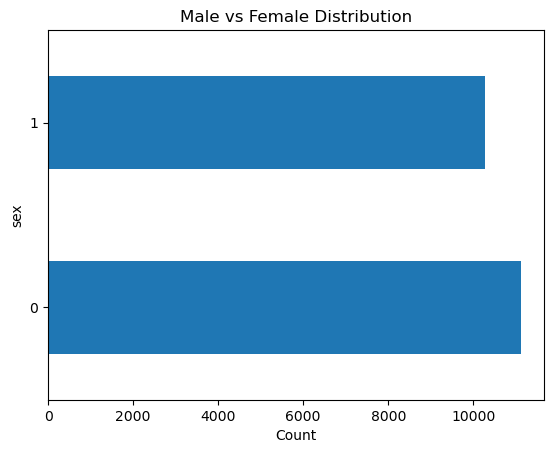

In [31]:
metadata['sex'].value_counts().plot(kind='barh')
plt.title('Male vs Female Distribution')
plt.xlabel('Count')
plt.show()

Again we can see that there are no Null values in the column `sex`.

#### `height`

Let's see how many Null values there are in `height`.

In [32]:
print("There are {} Null values in height: ".format(metadata['height'].isna().sum()))
print("{} of those are males".format(metadata[metadata['sex'] == 0]['height'].isna().sum()))
print("{} of those are females".format(metadata[metadata['sex'] == 1]['height'].isna().sum()))

There are 14470 Null values in height: 
7956 of those are males
6514 of those are females


Let's look at the distribution for male versus female and try to fill in those values. We can graphically compare the mean and median values of the height distribution of male versus female in our data and see which value to take to fill in our Null values. 

In [33]:
m_mean_height = round(metadata.groupby('sex')['height'].mean()[0], 1)
f_mean_height = round(metadata.groupby('sex')['height'].mean()[1], 1)

m_median_height = metadata.groupby('sex')['height'].median()[0]
f_median_height = metadata.groupby('sex')['height'].median()[1]

------Male Stats------
Mean Height: 173.5 cm
Median Height: 174.0 cm

-----Female Stats-----
Mean Height: 161.0 cm
Median Height: 160.0 cm


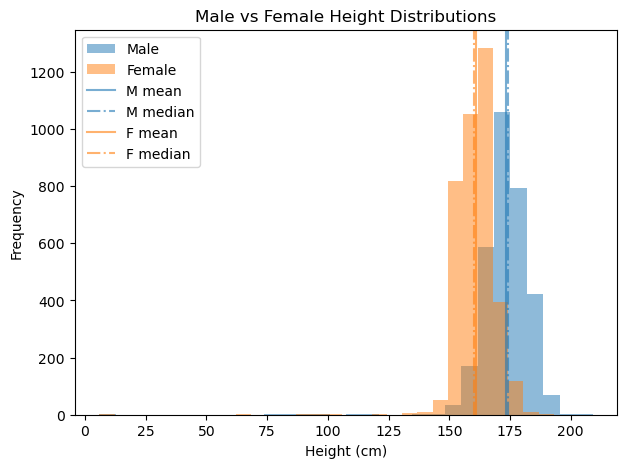

In [34]:
print("------Male Stats------")
print("Mean Height: {:.1f} cm".format(m_mean_height))
print("Median Height: {} cm". format(m_median_height))
print()
print("-----Female Stats-----")
print("Mean Height: {:.1f} cm".format(f_mean_height))
print("Median Height: {} cm".format(f_median_height))

plt.figure(figsize=(7,5))
metadata.groupby('sex')['height'].plot(kind='hist', bins=30, alpha=0.5)
plt.axvline(m_mean_height, c='C0', alpha=0.6)
plt.axvline(m_median_height, c='C0', ls='-.', alpha=0.6)
plt.axvline(f_mean_height, c='C1', alpha=0.6)
plt.axvline(f_median_height, c='C1', ls='-.', alpha=0.6)
plt.title("Male vs Female Height Distributions")
plt.xlabel("Height (cm)")
plt.legend(['Male', 'Female', 'M mean', 'M median', 'F mean', 'F median'])
plt.show()

Graphically, we see that male and female distributions separate look pretty normally distributed. We also see the mean and median values being pretty close to each other. As a result, let's fill in the Null values of male and female heights using their respective means. 

In [35]:
# Indices
m_index = (metadata['sex'] == 0) & (metadata['height'].isna())
f_index = (metadata['sex'] == 1) & (metadata['height'].isna())

# Fill 
metadata.loc[m_index, 'height'] = m_mean_height
metadata.loc[f_index, 'height'] = f_mean_height

In [36]:
# Sanity check
metadata['height'].isna().sum()

0

In [37]:
metadata.head()

patient_id   age  sex  height  weight  nurse  site     device  \
ecg_id                                                                  
1          15709.0  56.0    1   161.0    63.0    2.0   0.0  CS-12   E   
2          13243.0  19.0    0   173.5    70.0    2.0   0.0  CS-12   E   
3          20372.0  37.0    1   161.0    69.0    2.0   0.0  CS-12   E   
4          17014.0  24.0    0   173.5    82.0    2.0   0.0  CS-12   E   
5          17448.0  19.0    1   161.0    70.0    2.0   0.0  CS-12   E   

             recording_date                                  report  ...  \
ecg_id                                                               ...   
1       1984-11-09 09:17:34  sinusrhythmus periphere niederspannung  ...   
2       1984-11-14 12:55:37     sinusbradykardie sonst normales ekg  ...   
3       1984-11-15 12:49:10              sinusrhythmus normales ekg  ...   
4       1984-11-15 13:44:57              sinusrhythmus normales ekg  ...   
5       1984-11-17 10:43:15              sinusrhythmus normales ekg  ...   

        baseline_drift static_noise burst_noise  electrodes_problems  \
ecg_id                                                                 
1                  NaN    , I-V1,           NaN                  NaN   
2                  NaN          NaN         NaN                  NaN   
3                  NaN          NaN         NaN                  NaN   
4         , II,III,AVF          NaN         NaN                  NaN   
5        , III,AVR,AVF          NaN         NaN                  NaN   

        extra_beats  pacemaker  strat_fold                filename_lr  \
ecg_id                                                                  
1               NaN        NaN           3  records100/00000/00001_lr   
2               NaN        NaN           2  records100/00000/00002_lr   
3               NaN        NaN           5  records100/00000/00003_lr   
4               NaN        NaN           3  records100/00000/00004_lr   
5               NaN        NaN           4  records100/00000/00005_lr   

                      filename_hr diagnostic_superclass  
ecg_id                                                   
1       records500/00000/00001_hr                  NORM  
2       records500/00000/00002_hr                  NORM  
3       records500/00000/00003_hr                  NORM  
4       records500/00000/00004_hr                  NORM  
5       records500/00000/00005_hr                  NORM  

[5 rows x 27 columns]

#### `weight`
We can do something similar as what we did with height for weight.

In [38]:
print("There are {} Null values in weight: ".format(metadata['weight'].isna().sum()))
print("{} of those are males".format(metadata[metadata['sex'] == 0]['weight'].isna().sum()))
print("{} of those are females".format(metadata[metadata['sex'] == 1]['weight'].isna().sum()))

There are 12022 Null values in weight: 
6792 of those are males
5230 of those are females


Let's look at the distribution between male and female again but for weight this time. 

In [39]:
m_mean_weight = round(metadata.groupby('sex')['weight'].mean()[0], 1)
f_mean_weight = round(metadata.groupby('sex')['weight'].mean()[1], 1)

m_median_weight = metadata.groupby('sex')['weight'].median()[0]
f_median_weight = metadata.groupby('sex')['weight'].median()[1]

In [40]:
print("------Male Stats------")
print("Mean Weight: {:.1f} kg".format(m_mean_weight))
print("Median Weight: {} kg". format(m_median_weight))
print()
print("-----Female Stats-----")
print("Mean Weight: {:.1f} kg".format(f_mean_weight))
print("Median Weight: {} kg".format(f_median_weight))

plt.figure(figsize=(7,5))
metadata.groupby('sex')['weight'].plot(kind='hist', bins=30, alpha=0.5)
plt.axvline(m_mean_weight, c='C0', alpha=0.6)
plt.axvline(m_median_weight, c='C0', ls='-.', alpha=0.6)
plt.axvline(f_mean_weight, c='C1', alpha=0.6)
plt.axvline(f_median_weight, c='C1', ls='-.', alpha=0.6)
plt.title("Male vs Female Weight Distributions")
plt.xlabel("Weight (kg)")
plt.legend(['Male', 'Female', 'M mean', 'M median', 'F mean', 'F median'])
plt.show()

------Male Stats------
Mean Weight: 78.5 kg
Median Weight: 77.0 kg

-----Female Stats-----
Mean Weight: 64.6 kg
Median Weight: 63.0 kg


Here we see some difference in between the mean and median weights for both male and female, therefore instead of using the mean value we will impute our Null values with the median. 

In [41]:
# Indices
m_index = (metadata['sex'] == 0) & (metadata['weight'].isna())
f_index = (metadata['sex'] == 1) & (metadata['weight'].isna())

# Fill 
metadata.loc[m_index, 'weight'] = m_median_weight
metadata.loc[f_index, 'weight'] = f_median_weight

In [42]:
# Sanity check
metadata['weight'].isna().sum()

0

In [43]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21388 entries, 1 to 21837
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    21388 non-null  float64
 1   age                           21388 non-null  float64
 2   sex                           21388 non-null  int64  
 3   height                        21388 non-null  float64
 4   weight                        21388 non-null  float64
 5   nurse                         19949 non-null  float64
 6   site                          21372 non-null  float64
 7   device                        21388 non-null  object 
 8   recording_date                21388 non-null  object 
 9   report                        21388 non-null  object 
 10  heart_axis                    13228 non-null  object 
 11  infarction_stadium1           5600 non-null   object 
 12  infarction_stadium2           103 non-null    object 
 13  valida

#### `nurse`, `site`, `device`, `recording`
Let's look at the next couple of columns together. We have `nurse`, `site`, `device`, and `recording_date`. We can look at the distribution for each of these columns using `value_counts()`.

In [44]:
# Nurse
metadata['nurse'].value_counts()

nurse
0.0     8031
1.0     5648
5.0      644
3.0      638
2.0      634
7.0      634
4.0      632
6.0      625
10.0     620
8.0      619
11.0     613
9.0      611
Name: count, dtype: int64

The `nurse` column seems to tell us which nurse took the ECG.

In [45]:
# Site
metadata['site'].value_counts()

site
0.0     8671
1.0     6242
2.0     5019
3.0      550
4.0      100
5.0       57
6.0       46
7.0       43
8.0       43
9.0       38
10.0      36
11.0      32
12.0      25
14.0      25
15.0      25
13.0      24
16.0      22
17.0      20
21.0      18
20.0      18
18.0      17
26.0      15
29.0      15
19.0      15
28.0      15
22.0      15
27.0      15
24.0      14
32.0      13
23.0      13
25.0      13
31.0      13
34.0      12
30.0      12
36.0      12
35.0      11
37.0      10
33.0      10
38.0      10
40.0       9
41.0       9
39.0       8
44.0       7
43.0       6
45.0       6
42.0       6
48.0       4
46.0       4
47.0       4
49.0       3
50.0       2
Name: count, dtype: int64

On the other hand, `site` is telling us which site the ECG was taken at. 

In [46]:
# Device
metadata['device'].value_counts()

device
CS100    3    5886
CS-12         4003
AT-6 C 5.5    3921
CS-12   E     2865
AT-6     6    2252
AT-60    3     956
AT-6 C 5.8     818
AT-6 C         488
AT-6 C 5.0      75
AT-6 C 5.3      66
AT-6 C 5.6      58
Name: count, dtype: int64

`device` represents the device model used to record the ECG.

In [47]:
# Recording date
metadata['recording_date'].value_counts()

recording_date
1997-01-10 09:26:04    2
2000-08-08 09:34:05    2
1994-02-26 11:09:57    2
1992-02-06 11:47:42    2
1984-11-09 09:17:34    1
                      ..
1991-11-02 09:35:10    1
1991-11-01 13:59:45    1
1991-11-01 08:26:53    1
1991-10-31 18:17:27    1
2001-06-11 16:43:01    1
Name: count, Length: 21384, dtype: int64

`recording_date` gives us the date in which the ECG was recorded.

Looking at the unique values for each of our columns, we see that it is mainly extra information about the process of taking the ECG and not information about the patient themselves. Either way this information is not useful for us towards predicting ECG superclass and so we will drop these columns.

In [48]:
# Dropping column `nurse` since it does not provide useful information to our model
metadata.drop(columns=['nurse', 'site', 'device', 'recording_date'], inplace=True)

In [49]:
# Sanity check
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(metadata.head())

patient_id   age  sex  height  weight  \
ecg_id                                          
1          15709.0  56.0    1   161.0    63.0   
2          13243.0  19.0    0   173.5    70.0   
3          20372.0  37.0    1   161.0    69.0   
4          17014.0  24.0    0   173.5    82.0   
5          17448.0  19.0    1   161.0    70.0   

                                        report heart_axis infarction_stadium1  \
ecg_id                                                                          
1       sinusrhythmus periphere niederspannung        NaN                 NaN   
2          sinusbradykardie sonst normales ekg        NaN                 NaN   
3                   sinusrhythmus normales ekg        NaN                 NaN   
4                   sinusrhythmus normales ekg        NaN                 NaN   
5                   sinusrhythmus normales ekg        NaN                 NaN   

       infarction_stadium2  validated_by  second_opinion  \
ecg_id                                                     
1                      NaN           NaN           False   
2                      NaN           NaN           False   
3                      NaN           NaN           False   
4                      NaN           NaN           False   
5                      NaN           NaN           False   

        initial_autogenerated_report  validated_by_human  baseline_drift  \
ecg_id                                                                     
1                              False                True             NaN   
2                              False                True             NaN   
3                              False                True             NaN   
4                              False                True    , II,III,AVF   
5                              False                True   , III,AVR,AVF   

       static_noise burst_noise electrodes_problems extra_beats pacemaker  \
ecg_id                                                                      
1         , I-V1,           NaN                 NaN         NaN       NaN   
2               NaN         NaN                 NaN         NaN       NaN   
3               NaN         NaN                 NaN         NaN       NaN   
4               NaN         NaN                 NaN         NaN       NaN   
5               NaN         NaN                 NaN         NaN       NaN   

        strat_fold                filename_lr                filename_hr  \
ecg_id                                                                     
1                3  records100/00000/00001_lr  records500/00000/00001_hr   
2                2  records100/00000/00002_lr  records500/00000/00002_hr   
3                5  records100/00000/00003_lr  records500/00000/00003_hr   
4                3  records100/00000/00004_lr  records500/00000/00004_hr   
5                4  records100/00000/00005_lr  records500/00000/00005_hr   

       diagnostic_superclass  
ecg_id                        
1                       NORM  
2                       NORM  
3                       NORM  
4                       NORM  
5                       NORM

### Statements

**Report**

In [50]:
metadata['report'].value_counts()

report
sinus rhythm. normal ecg.                                                                                                                                                                                                                                          1734
sinusrhythmus lagetyp normal normales ekg                                                                                                                                                                                                                          1264
sinusrhythmus lagetyp normal normales ekg 4.46                          unbestÄtigter bericht                                                                                                                                                                      1045
sinusrhythmus normales ekg                                                                                                                                                                               

Given that the data is composed of words and sentences and is also not in english, we can drop this column.

In [51]:
metadata.drop(columns='report', inplace=True)

#### `heart_axis`

In [52]:
metadata['heart_axis'].value_counts()

heart_axis
MID     7625
LAD     3739
ALAD    1373
RAD      217
ARAD     121
AXL      101
AXR       49
SAG        3
Name: count, dtype: int64

The heart axis describes the overall direction of electrical activity during the depolarization stage. It represents the heart’s electrical axis in the Cabrera system [[1](#1)]. It is used to help with diagnosing the ECG signal, however in our case, since we already have the diagnosis this information does not help us with our classification. Therefore, we will also drop this column. 

In [53]:
# Drop heart axis
metadata.drop(columns='heart_axis', inplace=True)

In [54]:
# Sanity check 
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21388 entries, 1 to 21837
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    21388 non-null  float64
 1   age                           21388 non-null  float64
 2   sex                           21388 non-null  int64  
 3   height                        21388 non-null  float64
 4   weight                        21388 non-null  float64
 5   infarction_stadium1           5600 non-null   object 
 6   infarction_stadium2           103 non-null    object 
 7   validated_by                  12296 non-null  float64
 8   second_opinion                21388 non-null  bool   
 9   initial_autogenerated_report  21388 non-null  bool   
 10  validated_by_human            21388 non-null  bool   
 11  baseline_drift                1579 non-null   object 
 12  static_noise                  3206 non-null   object 
 13  burst_

#### `infarction_stadium1` and `infarction_stadium2`
Infarction stadium possibly refers to where there is a myocardial infarction detected in the ECG signal, when did it happen? Was it recently or long time ago. For further interpretation we can refer to a paper about the dataset found [here](#1).

In [55]:
# Count unique values 
metadata['infarction_stadium1'].value_counts()

infarction_stadium1
unknown           3419
Stadium III        980
Stadium II-III     943
Stadium I          165
Stadium II          88
Stadium I-II         5
Name: count, dtype: int64

In [56]:
# Count unique values 
metadata['infarction_stadium2'].value_counts()

infarction_stadium2
Stadium III    65
Stadium I      19
Stadium II     19
Name: count, dtype: int64

Since it does not provide valuable information to us we will drop them both. 

In [57]:
# Drop infarction_stadium1 and infarction_stadium2
metadata.drop(columns=['infarction_stadium1', 'infarction_stadium2'], inplace=True)

In [58]:
# Sanity check
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21388 entries, 1 to 21837
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    21388 non-null  float64
 1   age                           21388 non-null  float64
 2   sex                           21388 non-null  int64  
 3   height                        21388 non-null  float64
 4   weight                        21388 non-null  float64
 5   validated_by                  12296 non-null  float64
 6   second_opinion                21388 non-null  bool   
 7   initial_autogenerated_report  21388 non-null  bool   
 8   validated_by_human            21388 non-null  bool   
 9   baseline_drift                1579 non-null   object 
 10  static_noise                  3206 non-null   object 
 11  burst_noise                   581 non-null    object 
 12  electrodes_problems           28 non-null     object 
 13  extra_

#### `validated_by` and `second_opinion`
These ECGs were recorded and then validated by cardiologists, some of the results were verified by a second cardiologist. This is what the two columns `validated_by` and `second_opinion` represent. Since we do not need this information in our model, we can remove them.

In [59]:
# Dropping validated_by and second_opinion
metadata.drop(columns=['validated_by', 'second_opinion'], inplace=True)

In [60]:
# Sanity check
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21388 entries, 1 to 21837
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    21388 non-null  float64
 1   age                           21388 non-null  float64
 2   sex                           21388 non-null  int64  
 3   height                        21388 non-null  float64
 4   weight                        21388 non-null  float64
 5   initial_autogenerated_report  21388 non-null  bool   
 6   validated_by_human            21388 non-null  bool   
 7   baseline_drift                1579 non-null   object 
 8   static_noise                  3206 non-null   object 
 9   burst_noise                   581 non-null    object 
 10  electrodes_problems           28 non-null     object 
 11  extra_beats                   1882 non-null   object 
 12  pacemaker                     14 non-null     object 
 13  strat_

#### `initial_autogenerated_report` and `validated_by_human`
These two columns are just boolean columns letting us know if the report was autogenerated by an ECG device and whether the results were verified by a human cardiologist. As such we can also drop these columns too.

In [61]:
# Dropping initial_autogenerated_report and validated_by_human
metadata.drop(columns=['initial_autogenerated_report', 'validated_by_human'], inplace=True)

In [62]:
# Sanity check
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21388 entries, 1 to 21837
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   patient_id             21388 non-null  float64
 1   age                    21388 non-null  float64
 2   sex                    21388 non-null  int64  
 3   height                 21388 non-null  float64
 4   weight                 21388 non-null  float64
 5   baseline_drift         1579 non-null   object 
 6   static_noise           3206 non-null   object 
 7   burst_noise            581 non-null    object 
 8   electrodes_problems    28 non-null     object 
 9   extra_beats            1882 non-null   object 
 10  pacemaker              14 non-null     object 
 11  strat_fold             21388 non-null  int64  
 12  filename_lr            21388 non-null  object 
 13  filename_hr            21388 non-null  object 
 14  diagnostic_superclass  21388 non-null  object 
dtypes: floa

### Signal Metadata
Now let's look at the columns associated with the signals themselves.

#### `baseline_drift` 
Baseline drift or baseline wandering are low frequency waveforms present in ECG signals. They are usually caused by movements of sorts such as breathing, moving while taking the ECG, or even improper placement of electrodes. We know that there are a lot of Null values in this column, this is most likely for signals where baseline wandering is not present. Let's take a look at our column to see what values we have. 

In [63]:
# Unique values
metadata['baseline_drift'].unique()

array([nan, ' , II,III,AVF', ' , III,AVR,AVF', ' , V1', ' , II,AVF',
       ' , II-AVL,AVF', ' , V3', ' , III', ' , V6', ' , AVF',
       ' , II-AVF,V5,V6', ' , III,AVF', ' , II-AVF', ' , alles',
       ' , III,V3,V6', ' , I-AVR', ' , II-AVF,V5', ' , V5', ' , AVR',
       ' , V2', ' , II-V2', ' , V1V6', ' , II-V6', ' , V1 ', ' , AVL',
       ' , III,V4', ' , II,III,AVF-V6', ' , V5 ', ' , III,AVL', 'v5-6,  ',
       'v2,  ', ' , V1,2', ' , 1', ' , III,V1', ' , V4,V5',
       ' , III,V3-V6', ' , V1-V3', ' , V4', ' , III,V5,V6', 'V4,  ',
       ' , I-AVF,V5,V6', ' , V1,V6', ' , V4-V6', ' , V3,5,6',
       ' , I,II,AVR', ' , v4', ' , V5,V6', ' , II-V1', ' , I,III-V1',
       'v5,  ', ' , v6', ' , I-AVF', ' , v2', ' , v4-6', ' , v1-6',
       'v3,  ', 'v3, v1-6', ' , alle', ' , I,III,AVL,AVF', ' , I-AVL',
       ' , V1-V6', ' , III,AVF,V4', 'v6,  ', ' , v1', ' , v3, v6',
       ' , I-AVL,AVF', ' , I,II,AVR,V1', 'v3,6,  ', ' , II,III,AVL,AVF',
       'v2,3,  ', ' , V5,6', ' , 2', ' , V1,3,4,

Notice that this column actually tells us whether or not baseline drift is present in the patient ECG and which lead(s) it appears in. This is useful information for us, especially when we are cleaning our ECG signals, therefore we will keep the column. However, for values present, we will clean the punctuation and whitespaces in before and after the words. 

In [64]:
import string 

def remove_ws_punc(x):
    """Given a comma separated sentence in string format, remove the punctuation and whitespaces before 
    and after the sentence. Return the sentence with commas between words still in place. 
    """
    punc = string.punctuation
    
    if pd.isna(x):
        return 0
    
    new_word = []
    x = x.lstrip(' ')
    for word in x.split(','):    
        if word not in punc:
            new_word.append(word)

    x = ','.join(new_word).strip(' ').strip(',')
        
    return x

In [65]:
l = [' , II,III,AVF', ' , III,AVR,AVF', ' , V1', ' , II,AVF']

for word in l:
    print(remove_ws_punc(word))

II,III,AVF
III,AVR,AVF
V1
II,AVF


In [66]:
# Apply function to baseline drift column
metadata['baseline_drift'] = metadata['baseline_drift'].apply(remove_ws_punc)

In [67]:
metadata['baseline_drift'].unique()

array([0, 'II,III,AVF', 'III,AVR,AVF', 'V1', 'II,AVF', 'II-AVL,AVF', 'V3',
       'III', 'V6', 'AVF', 'II-AVF,V5,V6', 'III,AVF', 'II-AVF', 'alles',
       'III,V3,V6', 'I-AVR', 'II-AVF,V5', 'V5', 'AVR', 'V2', 'II-V2',
       'V1V6', 'II-V6', 'AVL', 'III,V4', 'II,III,AVF-V6', 'III,AVL',
       'v5-6', 'v2', 'V1,2', '1', 'III,V1', 'V4,V5', 'III,V3-V6', 'V1-V3',
       'V4', 'III,V5,V6', 'I-AVF,V5,V6', 'V1,V6', 'V4-V6', 'V3,5,6',
       'I,II,AVR', 'v4', 'V5,V6', 'II-V1', 'I,III-V1', 'v5', 'v6',
       'I-AVF', 'v4-6', 'v1-6', 'v3', 'v3, v1-6', 'alle', 'I,III,AVL,AVF',
       'I-AVL', 'V1-V6', 'III,AVF,V4', 'v1', 'v3, v6', 'I-AVL,AVF',
       'I,II,AVR,V1', 'v3,6', 'II,III,AVL,AVF', 'v2,3', 'V5,6', '2',
       'V1,3,4,6', 'v1,2', 'II-AVL', 'II-AVF,V6', 'I,III,AVL', 'V2-V5',
       'V3,V6', 'I,II,AVR,V2-V6', 'V1,3,5', 'V5 stark!', 'V2,V3',
       'II,III', 'I,II,V3', 'V1,V2', 'V1,V4-V6', 'V3 stark', 'alle, alle',
       'v3, 5', 'v1-2', 'I-V1', 'I-V6', 'I-AVL,V4,V5', 'v2,6', 'V5;V6',
     

#### `static_noise`

In [68]:
metadata['static_noise'].value_counts()

static_noise
, I-AVR,                     945
, I-AVF,                     909
, alles,                     495
, I-V1,                      155
, I-V2,                      140
                            ... 
, V5,V6,                       1
, I-AVL,V5,V6,                 1
, I,III,V5,                    1
, I,II,III,AVR,AVL,AVF,        1
, I-V1,V6,                     1
Name: count, Length: 123, dtype: int64

This is also useful information to us when we are cleaning our ECG signals, so we will keep it for now and clean the puncutuations.

In [69]:
metadata['static_noise'] = metadata['static_noise'].apply(remove_ws_punc)

In [70]:
metadata['static_noise'].value_counts()

static_noise
0                       18182
I-AVR                     945
I-AVF                     909
alles                     495
I-V1                      155
                        ...  
V5,V6                       1
I-AVL,V5,V6                 1
I,III,V5                    1
I,II,III,AVR,AVL,AVF        1
I-V1,V6                     1
Name: count, Length: 124, dtype: int64

In [71]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21388 entries, 1 to 21837
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   patient_id             21388 non-null  float64
 1   age                    21388 non-null  float64
 2   sex                    21388 non-null  int64  
 3   height                 21388 non-null  float64
 4   weight                 21388 non-null  float64
 5   baseline_drift         21388 non-null  object 
 6   static_noise           21388 non-null  object 
 7   burst_noise            581 non-null    object 
 8   electrodes_problems    28 non-null     object 
 9   extra_beats            1882 non-null   object 
 10  pacemaker              14 non-null     object 
 11  strat_fold             21388 non-null  int64  
 12  filename_lr            21388 non-null  object 
 13  filename_hr            21388 non-null  object 
 14  diagnostic_superclass  21388 non-null  object 
dtypes: floa

#### `burst_noise`
Burst noise are typically short in duration but high spikes in amplitude. We can see how much of our data is affected by this. 

In [72]:
print(f"Burst noise affects {metadata['burst_noise'].value_counts().sum()/metadata.shape[0]*100:.2f}% of our data.")

Burst noise affects 2.72% of our data.


We see that `burst_noise` does not affect much of our data and so we will disregard this column as well. Since we will be using Fourier Transforms to clean our signal, this should be taken care of. 

In [73]:
metadata.drop(columns='burst_noise', inplace=True)

#### `electrodes_problems`
Again, since this column only involves a very small portion of our data, we will ignore it and drop the column.

In [74]:
# Percentage of data affected by electrode problems
print(f"Electrodes problems affects {metadata['electrodes_problems'].value_counts().sum()/metadata.shape[0]*100:.2f}% of our data")

Electrodes problems affects 0.13% of our data


In [75]:
# Drop electrodes_problems
metadata.drop(columns='electrodes_problems', inplace=True)

In [76]:
# Sanity check
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21388 entries, 1 to 21837
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   patient_id             21388 non-null  float64
 1   age                    21388 non-null  float64
 2   sex                    21388 non-null  int64  
 3   height                 21388 non-null  float64
 4   weight                 21388 non-null  float64
 5   baseline_drift         21388 non-null  object 
 6   static_noise           21388 non-null  object 
 7   extra_beats            1882 non-null   object 
 8   pacemaker              14 non-null     object 
 9   strat_fold             21388 non-null  int64  
 10  filename_lr            21388 non-null  object 
 11  filename_hr            21388 non-null  object 
 12  diagnostic_superclass  21388 non-null  object 
dtypes: float64(4), int64(2), object(7)
memory usage: 2.3+ MB


#### `extra_beats`
We will also ignore this column, assuming that our models will not overfit to these noises.

In [77]:
metadata['extra_beats'].value_counts()

extra_beats
1ES                  402
SVES                 380
2ES                  175
VES1,alles           150
VES                  147
                    ... 
VES1,II-AVF,V4-V3      1
SVES1,I-AVF            1
2,V1,V5                1
VES3,V1-V4             1
4ES,SVES               1
Name: count, Length: 124, dtype: int64

In [78]:
# Drop column
metadata.drop(columns='extra_beats', inplace=True)

In [79]:
# Sanity check
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21388 entries, 1 to 21837
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   patient_id             21388 non-null  float64
 1   age                    21388 non-null  float64
 2   sex                    21388 non-null  int64  
 3   height                 21388 non-null  float64
 4   weight                 21388 non-null  float64
 5   baseline_drift         21388 non-null  object 
 6   static_noise           21388 non-null  object 
 7   pacemaker              14 non-null     object 
 8   strat_fold             21388 non-null  int64  
 9   filename_lr            21388 non-null  object 
 10  filename_hr            21388 non-null  object 
 11  diagnostic_superclass  21388 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 2.1+ MB


#### `pacemaker`
We can assume this column tells us whether or not the patient has a pacemaker. Let's look at the column values.

In [80]:
metadata['pacemaker'].value_counts()

pacemaker
ja, pacemaker    8
ja, nan          3
PACE????, nan    2
?, nan           1
Name: count, dtype: int64

We can do some feature engineering by converting all the columns that has pacemaker as True and ones without to False.

In [81]:
# Change Null values to 0
metadata['pacemaker'] = np.where(~metadata['pacemaker'].isna(), metadata['pacemaker'], 0)

In [82]:
# Change values with the word `pacemaker` in it to 1 and everything else 0
metadata['pacemaker'] = np.where(metadata['pacemaker'] == 'ja, pacemaker', 1, 0)

In [83]:
# Sanity check
metadata['pacemaker'].value_counts()

pacemaker
0    21380
1        8
Name: count, dtype: int64

#### `strat_fold`
Finally we can look at our last column `strat_fold`. Let's do a value counts.

In [84]:
metadata['strat_fold'].value_counts()

strat_fold
10    2158
3     2150
9     2146
1     2139
2     2138
5     2135
7     2134
4     2130
8     2129
6     2129
Name: count, dtype: int64

Looking through the documentation given by [Wagner et al. (2020)](#1), we find that `strat_fold` is a label encoding for the  data set where ECGs labeled with 9 or 10 have particularly higher label quality, intended to be used as validation set and test set respectively. This labeling was done based on existing multilabel stratification methods from the literature at the time this data set was published. As a result, we will keep this column and use it for when we perform train test split. 

### Export as CSV
Now we can export this new `metadata` file as a CSV for us to use it in our next notebook. 

In [85]:
metadata

patient_id    age  sex  height  weight baseline_drift static_noise  \
ecg_id                                                                       
1          15709.0   56.0    1   161.0    63.0              0         I-V1   
2          13243.0   19.0    0   173.5    70.0              0            0   
3          20372.0   37.0    1   161.0    69.0              0            0   
4          17014.0   24.0    0   173.5    82.0     II,III,AVF            0   
5          17448.0   19.0    1   161.0    70.0    III,AVR,AVF            0   
...            ...    ...  ...     ...     ...            ...          ...   
21833      17180.0   67.0    1   161.0    63.0              0        alles   
21834      20703.0  300.0    0   173.5    77.0              0            0   
21835      19311.0   59.0    1   161.0    63.0              0        I-AVR   
21836       8873.0   64.0    1   161.0    63.0              0            0   
21837      11744.0   68.0    0   173.5    77.0              0        I-AVL   

        pacemaker  strat_fold                filename_lr  \
ecg_id                                                     
1               0           3  records100/00000/00001_lr   
2               0           2  records100/00000/00002_lr   
3               0           5  records100/00000/00003_lr   
4               0           3  records100/00000/00004_lr   
5               0           4  records100/00000/00005_lr   
...           ...         ...                        ...   
21833           0           7  records100/21000/21833_lr   
21834           0           4  records100/21000/21834_lr   
21835           0           2  records100/21000/21835_lr   
21836           0           8  records100/21000/21836_lr   
21837           0           9  records100/21000/21837_lr   

                      filename_hr diagnostic_superclass  
ecg_id                                                   
1       records500/00000/00001_hr                  NORM  
2       records500/00000/00002_hr                  NORM  
3       records500/00000/00003_hr                  NORM  
4       records500/00000/00004_hr                  NORM  
5       records500/00000/00005_hr                  NORM  
...                           ...                   ...  
21833   records500/21000/21833_hr                  STTC  
21834   records500/21000/21834_hr                  NORM  
21835   records500/21000/21835_hr                  STTC  
21836   records500/21000/21836_hr                  NORM  
21837   records500/21000/21837_hr                  NORM  

[21388 rows x 12 columns]

In [86]:
metadata.to_csv('../data/cleaned_metadata.csv')

### Conclusion
Having gone through the patient information data, we can move on to the ECG signals themselves for preprocessing and baseline modeling. This can be found in the `ecg_cleaning` notebook. 

<a id='references'></a>
## References

<a id='1'></a>
[1] Wagner, P., Strodthoff, N., Bousseljot, RD. et al. PTB-XL, a large publicly available electrocardiography dataset. Sci Data 7, 154 (2020). https://doi.org/10.1038/s41597-020-0495-6